In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing as SES

warnings.filterwarnings("ignore") 

In [2]:
df = pd.read_csv("data/[1h]BTCUSDT.csv", 
                 parse_dates=['Start', 'Stop'], 
                 date_parser=lambda x: datetime.datetime.fromtimestamp(float(x)/1000))
df.columns = ["start", "stop", "open", "close", "high", "low", "volume"]

In [3]:
df.head()

,start,stop,open,close,high,low,volume
0,2017-08-17 07:00:00,2017-08-17 07:59:59.999,4261.48,4308.83,4261.32,4313.62,47.181009
1,2017-08-17 08:00:00,2017-08-17 08:59:59.999,4308.83,4315.32,4291.37,4328.69,23.234916
2,2017-08-17 09:00:00,2017-08-17 09:59:59.999,4330.29,4324.35,4309.37,4345.45,7.229691
3,2017-08-17 10:00:00,2017-08-17 10:59:59.999,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 11:00:00,2017-08-17 11:59:59.999,4333.32,4360.69,4333.32,4377.85,0.972807


### Autocorrelation test

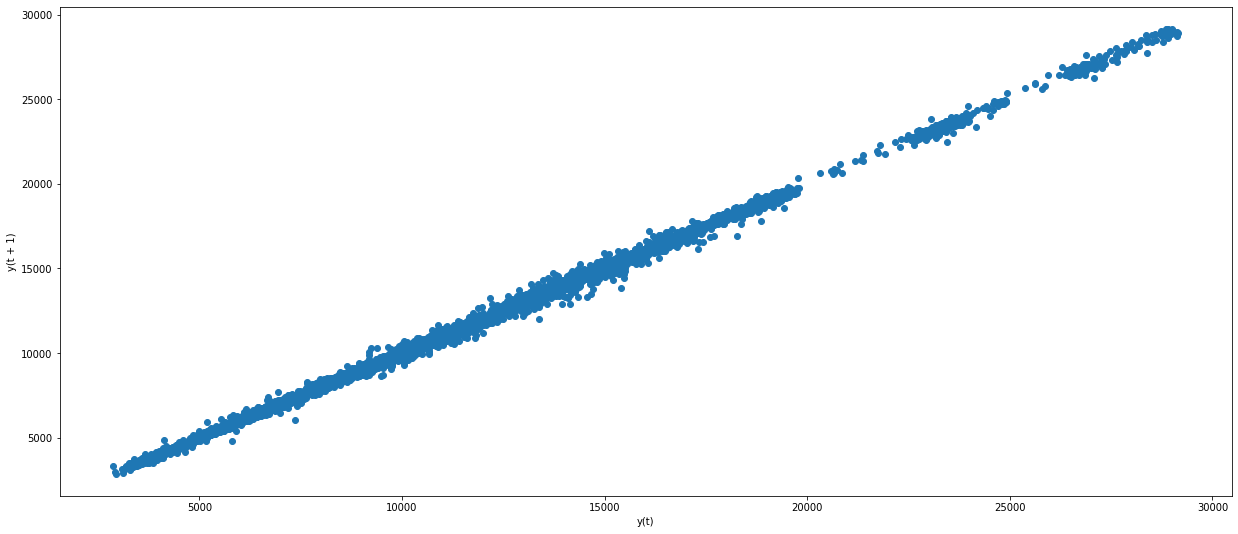

In [4]:
plt.rc("figure", figsize=(21, 9))
pd.plotting.lag_plot(df.open)

plt.show()

### PACF and ACF

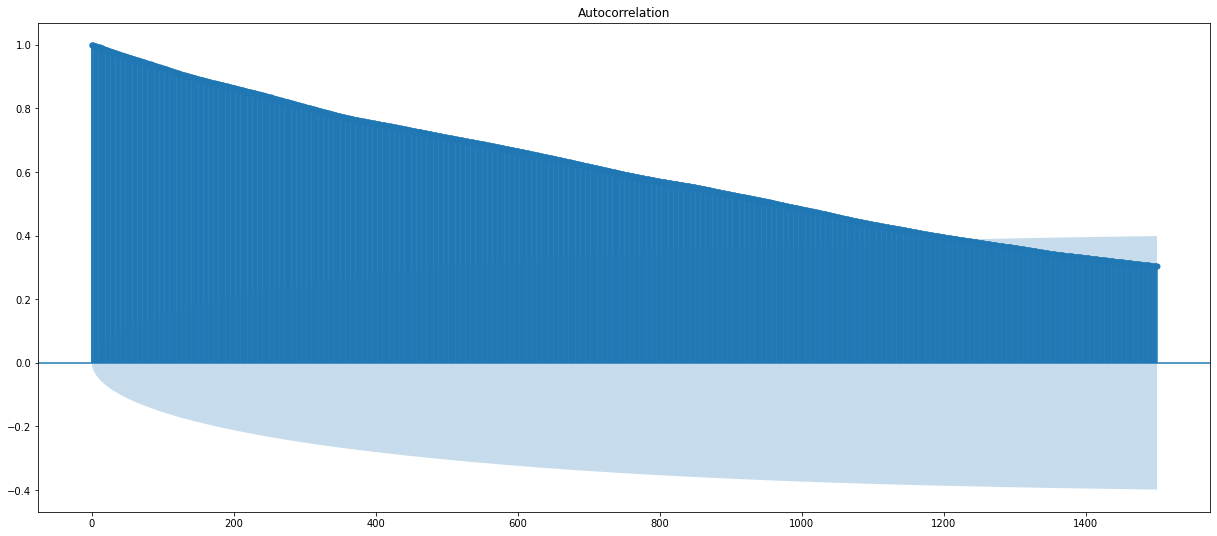

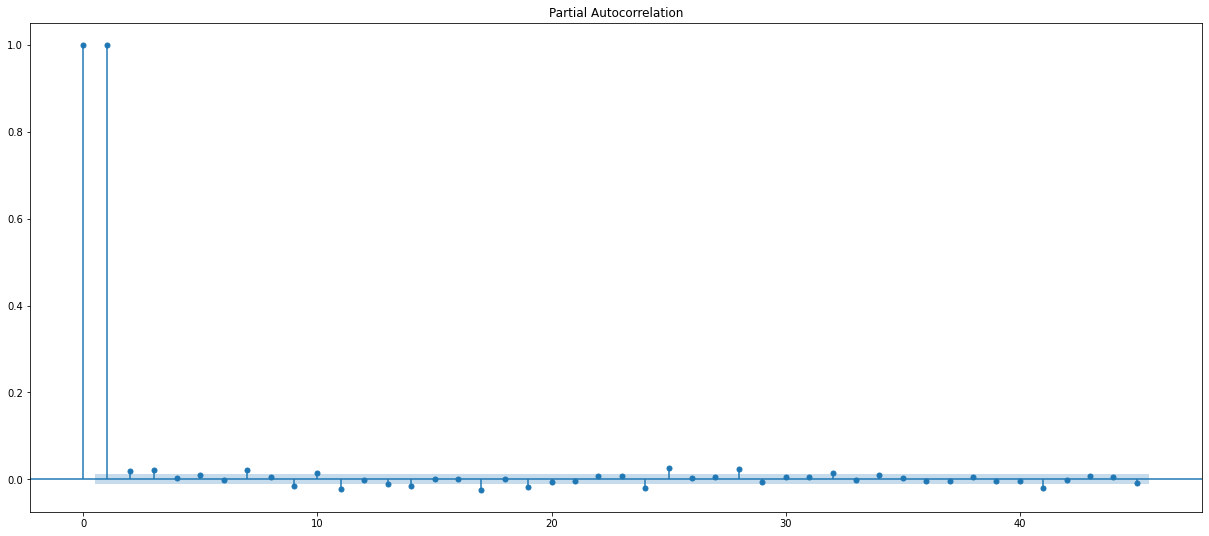

In [5]:
plt.rc("figure", figsize=(21, 9))

plot_acf(df.open, lags=1500)
plt.show()

plot_pacf(df.open)
plt.show()

p = 1250

q = 3

### Autoregression (AR)

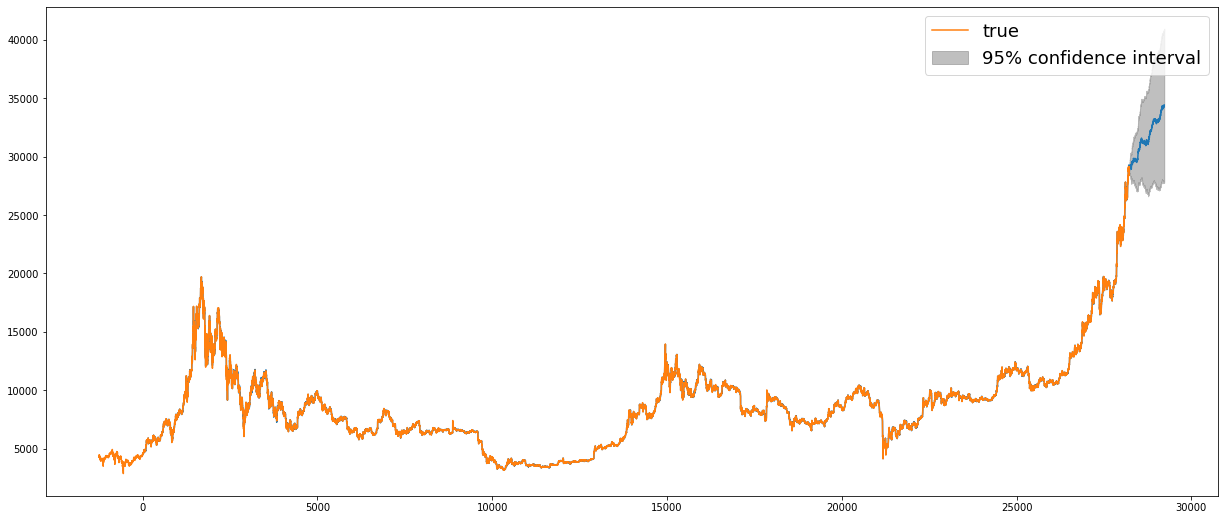

In [6]:
p = 1250

model_ar = AutoReg(df.open.values, lags=p, old_names=False).fit()

model_ar.plot_predict(start=0, end=len(df.open.values) + 1000, figsize=(21, 9))
plt.plot(range(-p, len(df.open)-p), df.open.values, label="true")

predict_ar = model_ar.predict(0, len(df.open.values))
rmse_ar = np.sqrt(mean_squared_error(df.open[p-1:].values, predict_ar))

plt.legend(fontsize=18)
plt.show()

### Moving Average (MA)

<Figure size 1512x648 with 0 Axes>

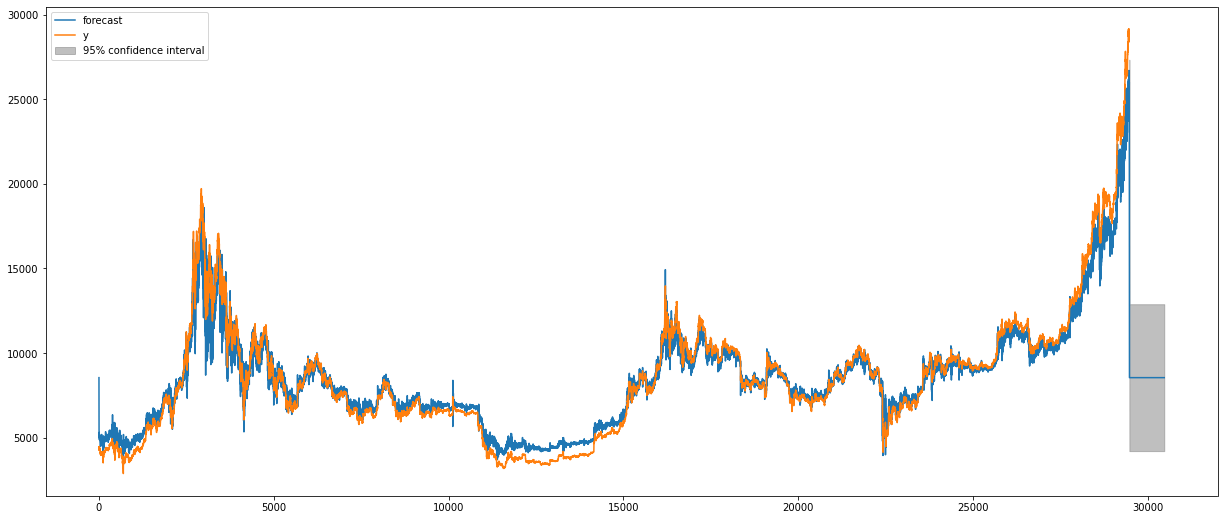

In [7]:
model_ma = ARIMA(df.open.values, order=(0, 0, 3)).fit()

plt.figure(figsize=(21, 9))

predict_ma = model_ma.predict(1, len(df.open.values))
rmse_ma = np.sqrt(mean_squared_error(df.open.values, predict_ma))

model_ma.plot_predict(start=0, end=len(df.open)+1000)
plt.show()

# 

### SimpleExpSmoothing

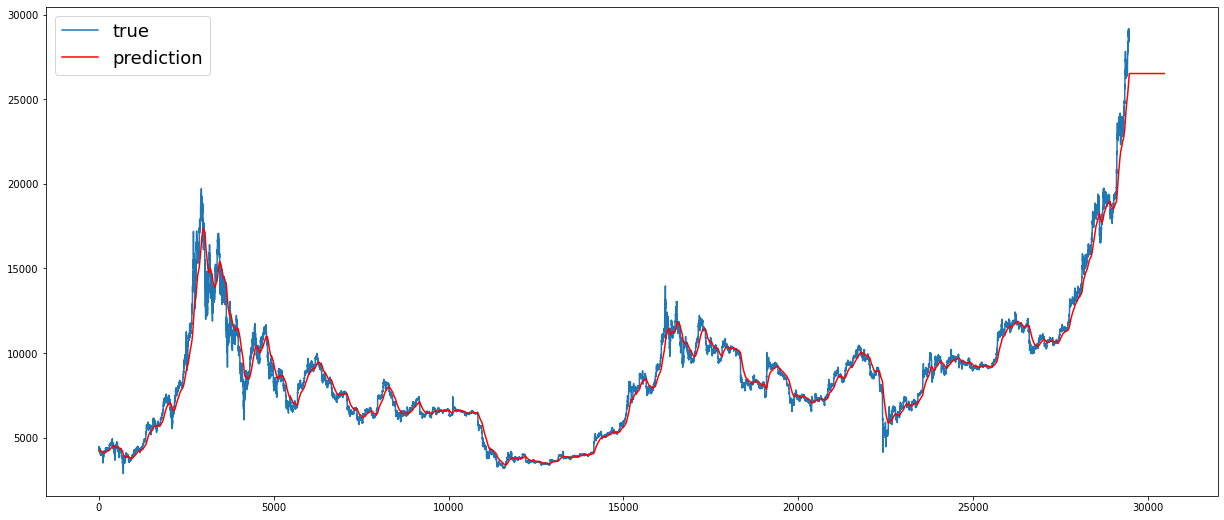

In [8]:
model_ses = SES(df.open, initialization_method="heuristic").fit(smoothing_level=0.01)

predict_ses = model_ses.predict(0, len(df.open)+1000)

rmse_ses = np.sqrt(mean_squared_error(df.open.values, predict_ses[:-1001]))

plt.figure(figsize=(21, 9))

plt.plot(df.open, label="true")
plt.plot(predict_ses, 'r', label="prediction")

plt.legend(fontsize=18)
plt.show()

# 

### Holt Winter’s Exponential Smoothing 

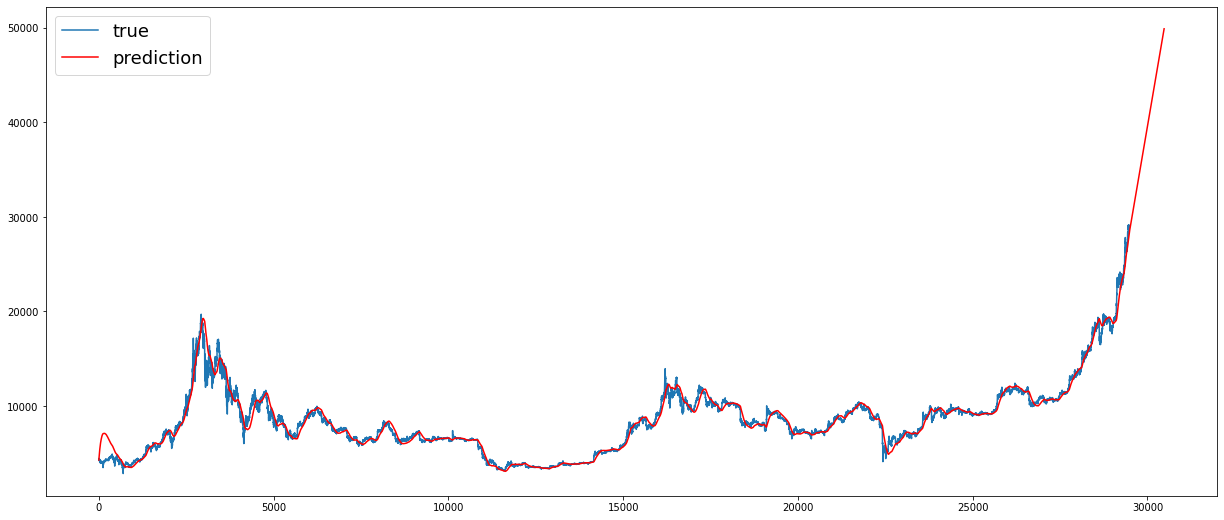

In [9]:
model_hwes = ExponentialSmoothing(df.open, trend = 'add').fit(smoothing_level=0.01)

predict_hwes = model_hwes.predict(0, len(df.open) + 1000)

rmse_hwes = np.sqrt(mean_squared_error(df.open.values, predict_hwes[:-1001]))

plt.figure(figsize=(21, 9))

plt.plot(df.open, label="true")
plt.plot(predict_hwes, 'red', label="prediction")

plt.legend(fontsize=18)
plt.show()

# 

### Compare results 

In [10]:
print("AR RMSE: {0}".format(rmse_ar))
print("MA RMSE: {0}".format(rmse_ma))
print("SES RMSE: {0}".format(rmse_ses))
print("HWES RMSE: {0}".format(rmse_hwes))

AR RMSE: 36.39237414814989
MA RMSE: 666.3029162988563
SES RMSE: 624.6765129381549
HWES RMSE: 642.990590008672


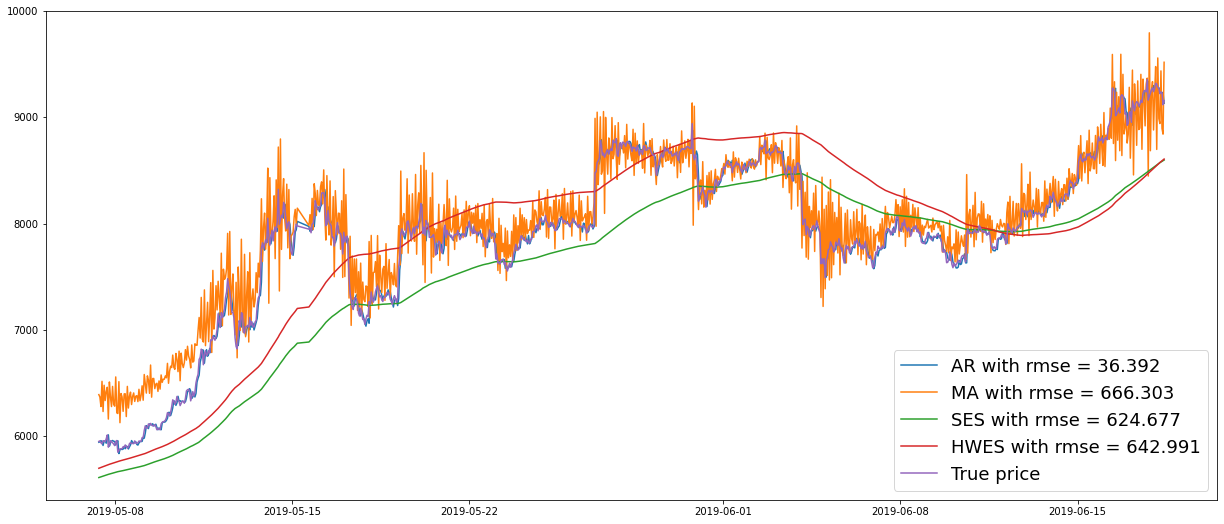

In [11]:
time = df.start[15000:16000]
true_plot = df.open[15000:16000]
ar_plot = predict_ar[13750:14750]
ma_plot = predict_ma[15000:16000]
ses_plot = predict_ses[:-1001][15000:16000]
hwes_plot = predict_hwes[:-1001][15000:16000]

plt.rc("figure", figsize=(21, 9))
plt.plot(time, ar_plot, label="AR with rmse = {0}".format(round(rmse_ar, 3)))
plt.plot(time, ma_plot, label="MA with rmse = {0}".format(round(rmse_ma, 3)))
plt.plot(time, ses_plot, label="SES with rmse = {0}".format(round(rmse_ses, 3)))
plt.plot(time, hwes_plot, label="HWES with rmse = {0}".format(round(rmse_hwes, 3)))
plt.plot(time, true_plot, label="True price")

plt.legend(fontsize=18)
plt.show()